In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
training_examples=10000
testing_examples=1000
sample_gap=0.01
timesteps=20

生成训练数据  输入是20个时间步长的时序数据，输出标签是第21个时序时刻的seq数据

In [4]:
def generate_data(seq):
    x=[]
    y=[]
    for i in range(len(seq)-timesteps-1):
        x.append(seq[i:i+timesteps])#20个为一组 是二维
        y.append(seq[i+timesteps])#一维数组就是第21个被预测的值
    return np.array(x,dtype=np.float32),np.array(y,dtype=np.float32)

In [5]:
l=np.linspace(0,100,100)#0-100之间随机生成100个数

In [6]:
test_start=training_examples*sample_gap
#10000*0.01=100
test_end=test_start+testing_examples*sample_gap
#100+1000*0.01=110
train_x,train_y=generate_data(np.sin(np.linspace(0,test_start,training_examples)))
#0--100之间 生成10000个数字  投放到sin带入生成器中
test_x,test_y=generate_data(np.sin(np.linspace(test_start,test_end,testing_examples)))
#同上
print(np.shape(train_x),np.shape(train_y),np.shape(test_x),np.shape(test_y))

(9979, 20) (9979,) (979, 20) (979,)


# 构建RNN

In [7]:
lstm_size=20
#隐藏层中lstm的数量，time_step=数目是时间维度，就是之前多少个结果来作为输入，
lstm_layers=3
#lstm_size代表数据维度 2个lstm并行处理 输出两个结果 对output没有影响  但是对状态的输出有影响
batch_size=64
#权重更新大小
#输入数据维度64*20*1
#输出数据维度64*20*4

In [8]:
x=tf.placeholder(tf.float32,[None,timesteps,1],name='input_x')
#dynamic_rnn需要三维的数据输入，增加的一维是留给batch的64*20*1,1代表的是输入单个时间步长下输入数据维度是1  
y=tf.placeholder(tf.float32,[None,1],name='input_y')
keep_prob=tf.placeholder(tf.float32,name='keep_prob')#保持节点的概率

In [9]:
#定义lstm以及每一层跟着的防过拟合drop率
lstm=tf.contrib.rnn.BasicLSTMCell(lstm_size)
drop=tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(lstm_size)#定义20个lstm
cell=tf.contrib.rnn.MultiRNNCell([lstm_cell()for _ in range(lstm_layers)])
outputs,final_state=tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
#保留最后一个步长的输出作为最新的预测输出  投入全连接层中
outputs=outputs[:,-1,:]
#全连接
predictions=tf.contrib.layers.fully_connected(outputs,1,activation_fn=tf.tanh)
#损失函数
cost=tf.losses.mean_squared_error(y,predictions)
#优化器
optimizer=tf.train.AdamOptimizer().minimize(cost)

# 设计一个迭代器

In [10]:
def get_batches(x,y,batch_size=64):
    for i in range(0,len(x),batch_size):
        begin_i=i
        end_i=i+batch_size if (i+batch_size)<len(x) else len(x)
        yield x[begin_i:end_i,:],y[begin_i:end_i]

In [11]:
batch=get_batches(train_x,train_y)
batch_x,batch_y=next(batch)
print(np.shape(batch_x),np.shape(batch_y))

(64, 20) (64,)


In [16]:
epochs=50
session=tf.Session()
with session.as_default() as sess:
    #初始化
    tf.global_variables_initializer().run()
    iteration=1
    for e in range(1,epochs+1):
        for xs,ys in get_batches(train_x,train_y,batch_size):
            #与x,y的占位符一致
            feed_dict={x:xs[:,:,None],y:ys[:,None],keep_prob:0.8}
            outputs_,final_state_=sess.run([outputs,final_state],feed_dict=feed_dict)
            predictions_=sess.run([predictions],feed_dict=feed_dict)
            loss,_=sess.run([cost,optimizer],feed_dict=feed_dict)
            
        if e%5==0:
            #if iteration %100==0:
            print('Epochs:{}/{}'.format(e,epochs),
                  'Train loss:{:.8f}'.format(loss),
                  'output shape:',np.shape(outputs_),
                  'final_state shape:',np.shape(final_state_),
                  'prediction shape:',np.shape(predictions_))
            #iteration+=1  

Epochs:5/50 Train loss:0.01217277 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:10/50 Train loss:0.00023438 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:15/50 Train loss:0.00039759 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:20/50 Train loss:0.00056791 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:25/50 Train loss:0.00055517 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:30/50 Train loss:0.00050306 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:35/50 Train loss:0.00045406 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:40/50 Train loss:0.00038445 output shape: (59, 20) final_state shape: (3, 2, 59, 20) prediction shape: (1, 59, 1)
Epochs:45/50 Train loss:0.0004383

In [17]:
print(np.shape(outputs_))
print(np.shape(final_state_))

(59, 20)
(3, 2, 59, 20)


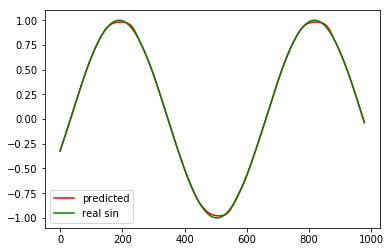

In [18]:
with session.as_default() as sess:
    #结果
    feed_dict={x:test_x[:,:,None],keep_prob:1.0}
    results=sess.run(predictions,feed_dict=feed_dict)
    plt.plot(results,'r',label='predicted')
    plt.plot(test_y,'g-',label='real sin')
    plt.legend()
    plt.show()